# Azure Computer Vision 4 (Florence)
## Fashion visual search demo with Azure Computer Vision 4 Florence

<img src="https://github.com/retkowsky/images/blob/master/florence/fashionheader.png?raw=true">
<br>
<i>Note: this image was generated with Azure Open AI Dall-e 2</i>

### Visual search with vector embeddings
**Vector embeddings** are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

<img src="https://github.com/retkowsky/images/blob/master/florence/embeddings.jpg?raw=true">

### Business applications
- **Digital asset management**: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- **Medical image retrieval**: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- **Security and surveillance**: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- **Forensic image retrieval**: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- **E-commerce**: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- **Fashion and design**: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

### Visual Search Process
<img src="https://github.com/retkowsky/images/blob/master/florence/fashionprocess.png?raw=true" width="480">

### Image Retrieval with Azure Computer Vision Documentation
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-image-retrieval
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/how-to/image-retrieval

### Demo images
Demo images are a sample of this collection of images: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
<br><br>
> Serge Retkowsky | Microsoft | https://github.com/retkowsky | 18th of April, 2023

## Table of contents

1. [Librairies](#chapt1)

2. [Informations](#chapt2)

3. [Our products images](#chapt3)

4. [Vectors embedding generation for all the catalog images](#chapt4)

## 1. <a name="chapt1"></a> Librairies

In [1]:
#%pip install --upgrade nomic

In [2]:
import datetime
import glob
import json
import multiprocessing
import numpy as np
import nomic
import os
import sys
import time

from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv
from nomic import atlas
from PIL import Image
from tqdm import tqdm

In [3]:
load_dotenv("visualsearch.env")

key = os.getenv('azure_cv_key')
endpoint = os.getenv("azure_cv_endpoint")

### Importing our specific functions

In [4]:
pyfile = "visualsearch.py"

print("Python file:", pyfile,
      "Date:", time.ctime(os.path.getmtime(pyfile)))

Python file: visualsearch.py Date: Tue Apr 18 09:10:01 2023


In [5]:
from visualsearch import (
    image_embedding_batch,
    view_image,
)

## 2. <a name="chapt2"></a> Informations

In [6]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [7]:
print("Today is", datetime.datetime.today())

Today is 2023-04-19 11:16:22.125743


## 3. <a name="chapt3"></a> Our products images

In [8]:
IMAGES_DIR = "fashion"

In [9]:
image_files = glob.glob(IMAGES_DIR + "/*")

print("Directory of images:", IMAGES_DIR)
print("Total number of catalog images =", "{:,}".format(len(image_files)))

Directory of images: fashion
Total number of catalog images = 1,473


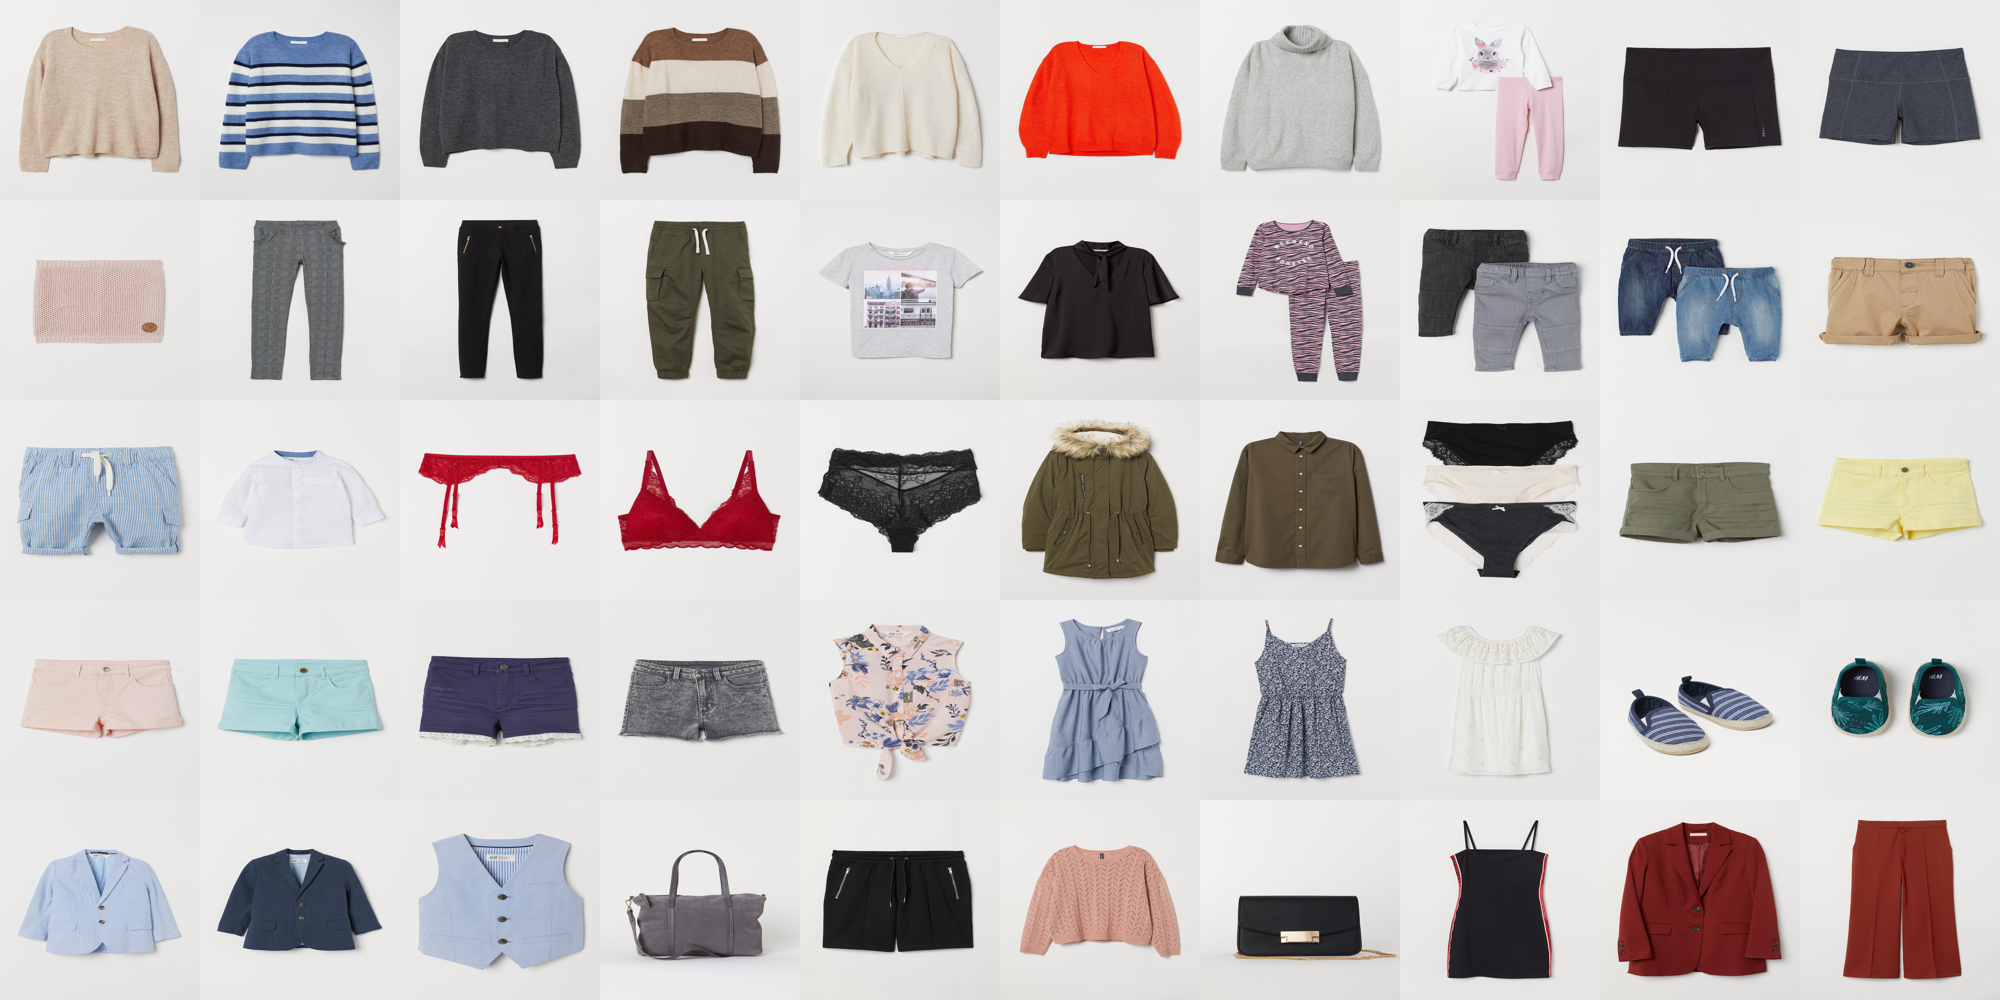

In [10]:
num_images_per_row = 10
num_images_per_col = 5
img_size = 200
start = 1000

samples = image_files[start:start + (num_images_per_row * num_images_per_col)]

samples_images = Image.new(
    'RGB', (num_images_per_row * img_size, num_images_per_col * img_size))

# Load and resize the images
sample_images = [
    Image.open(image_file).resize((img_size, img_size))
    for image_file in samples
]

# Paste the images onto the new image
for idx, img in enumerate(sample_images):
    x = (idx % num_images_per_row) * img_size
    y = (idx // num_images_per_row) * img_size
    samples_images.paste(img, (x, y))

samples_images

## 4. <a name="chapt4"></a> Vectors embedding generation for the catalog images

In [11]:
num_cores = multiprocessing.cpu_count()

print("Number of CPU cores =", num_cores)

Number of CPU cores = 8


In [12]:
def process_image(image_file, max_retries=20):
    """
    Process image with error management
    """
    num_retries = 0

    while num_retries < max_retries:
        try:
            embedding, response = image_embedding_batch(image_file)

            if response.status_code == 200:
                return embedding

            else:
                num_retries += 1
                print(f"Error processing {image_file}: {response.status_code}.\
                Retrying... (attempt {num_retries} of {max_retries})")

        except Exception as e:
            print(f"An error occurred while processing {image_file}: {e}")
            print(f"Retrying... (attempt {num_retries} of {max_retries})")
            num_retries += 1

    return None

In [13]:
def process_all_images(image_files, max_workers=4, max_retries=20):
    """
    Running the full process using pool
    """
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        embeddings = list(
            tqdm(executor.map(lambda x: process_image(x, max_retries),
                              image_files),
                 total=len(image_files)))

    return [emb for emb in embeddings if emb is not None]

### Running the images vectors embeddings

In [14]:
print(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"),
      "Starting to compute vector embeddings for our",
      "{:,}".format(len(image_files)), "catalog images...")
start = time.time()

# Running the images vector embeddings for all the images files
list_emb = process_all_images(image_files, max_workers=4, max_retries=20)

# End of job
print(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"), "Done")
elapsed = time.time() - start
print(
    f"\nElapsed time: {int(elapsed / 60)} minutes, {int(elapsed % 60)} seconds"
)
print("Number of processed images =", len(list_emb))
print(f"Processing time per image = {(elapsed / len(list_emb)):.5f} sec")

19-Apr-2023 11:16:41 Starting to compute vector embeddings for our 1,473 catalog images...


100%|██████████| 1473/1473 [09:44<00:00,  2.52it/s]

19-Apr-2023 11:26:26 Done

Elapsed time: 9 minutes, 44 seconds
Number of processed images = 1473
Processing time per image = 0.39710 sec


> Note: this process can be long (1 hour in this example)

In [15]:
print(f"Number of images files = {len(image_files)}")
print(f"Number of vectors embeddings = {len(list_emb)}")

Number of images files = 1473
Number of vectors embeddings = 1473


### Exporting the images vectors embeddings into a json file

In [16]:
JSON_DIR = 'json'

os.makedirs(JSON_DIR, exist_ok=True)

In [17]:
print("Exporting images vector embeddings")

# Json filename
current_dt = str(datetime.datetime.today().strftime('%d%b%Y_%H%M%S'))
json_file = os.path.join(JSON_DIR, f'img_embed_{current_dt}.json')

# Saving vectors embeddings into this Json file
with open(json_file, 'w') as f:
    json.dump(list_emb, f)

print("Done. Vector embeddings have been saved in:", json_file)

Exporting images vector embeddings
Done. Vector embeddings have been saved in: json/img_embed_19Apr2023_112639.json


### Exported file

In [18]:
!ls $json_file -lh

-rwxrwxrwx 1 root root 17M Apr 19 11:26 json/img_embed_19Apr2023_112639.json


In [19]:
# List of all Json files
json_list = [
    os.path.join(JSON_DIR, file) for file in os.listdir(JSON_DIR)
    if file.endswith('.json')
]

json_list

['json/img_embed_19Apr2023_112639.json']

### Importing the embeddings from a local file

In [20]:
print("Importing vectors embeddings...")

JSON_DIR = "json"

jsonfiles = [entry.name for entry in os.scandir(JSON_DIR) if entry.is_file()]
jsonfiles = [f for f in jsonfiles if os.path.isfile(os.path.join(JSON_DIR, f))]

# Get the most recent file
modification_times = [(f, os.path.getmtime(os.path.join(JSON_DIR, f)))
                      for f in jsonfiles]
modification_times.sort(key=lambda x: x[1], reverse=True)
most_recent_file = JSON_DIR + '/' + modification_times[0][0]

# Loading the most recent file
print(
    f"Loading the most recent file of the vector embeddings: {most_recent_file}"
)

with open(most_recent_file) as f:
    list_emb = json.load(f)

print(f"\nDone: number of imported vector embeddings = {len(list_emb):,}")

Importing vectors embeddings...
Loading the most recent file of the vector embeddings: json/img_embed_19Apr2023_112639.json

Done: number of imported vector embeddings = 1,473


## 5. Visualizing the images vectors embeddings

During indexing, **Atlas** builds a contextual **two-dimensional data map of embeddings**. <br>
This map preserves high-dimensional relationships present between embeddings in a two-dimensional,
human interpretable view.

https://github.com/nomic-ai/nomic

You can get a free key at https://atlas.nomic.ai/cli-login

In [21]:
# Getting the atlas nomic key from our .env file
load_dotenv("visualsearch.env")

atlas_nomic_key = os.getenv('atlas_nomic_key')

In [22]:
nomic.login(atlas_nomic_key)

In [23]:
datapoints = [{
    'filename': image_file_name,
    'id': i
} for i, image_file_name in enumerate(image_files)]

In [24]:
project = atlas.map_embeddings(
    embeddings=np.array(list_emb),  # images vector embeddings
    data=datapoints,  # datapoints
    id_field="id",  # id to be used
    name="image_file_name",  # image filename
    reset_project_if_exists=True,
    is_public=True,  # public map
)

map = project.get_map(
    "Images vector embeddings with Azure Computer Vision 4 Florence")
print(map)

2023-04-19 11:26:50.859 | INFO     | nomic.project:__init__:871 - Found existing project `image_file_name` in organization `seretkow`. Clearing it of data by request.
2023-04-19 11:26:51.949 | INFO     | nomic.project:_create_project:965 - Creating project `image_file_name` in organization `seretkow`
2023-04-19 11:26:53.314 | INFO     | nomic.atlas:map_embeddings:100 - Uploading embeddings to Atlas.
2023-04-19 11:26:53.381 | WARNING  | nomic.project:_validate_and_correct_arrow_upload:244 - id_field is not a string. Converting to string from int32
1it [00:04,  4.10s/it]
2023-04-19 11:26:57.485 | INFO     | nomic.project:_add_data:1577 - Upload succeeded.
2023-04-19 11:26:57.486 | INFO     | nomic.atlas:map_embeddings:119 - Embedding upload succeeded.
2023-04-19 11:26:58.727 | INFO     | nomic.project:create_index:1282 - Created map `image_file_name` in project `image_file_name`: https://atlas.nomic.ai/map/aac8338b-3b3e-4bc1-a1dc-0ef2de8256f8/39e16fe3-d1f4-4eb2-972d-090f6263af2e
2023-04-

image_file_name: https://atlas.nomic.ai/map/aac8338b-3b3e-4bc1-a1dc-0ef2de8256f8/39e16fe3-d1f4-4eb2-972d-090f6263af2e


### We can take for example two nearest points and view the images. We can see that they are quite similar.

In [25]:
point1 = "fashion/0622271001.jpg"
point2 = "fashion/0641187002.jpg"

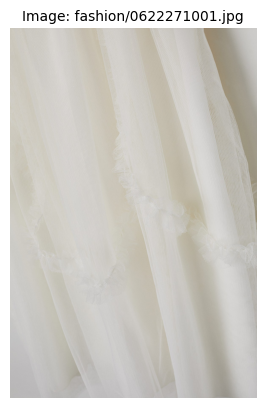

In [26]:
view_image(point1)

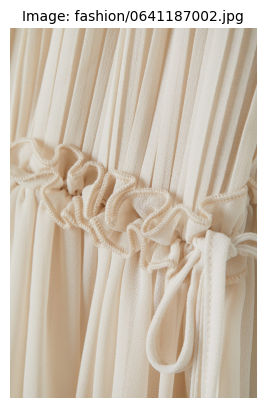

In [27]:
view_image(point2)

### An example of a map:

<img src="https://github.com/retkowsky/images/blob/master/florence/map1.png?raw=true">

> In the next notebook we will do some visual search 